<a href="https://colab.research.google.com/github/lyffreya/Robustness/blob/main/project_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install Wand

In [ ]:
!sudo apt-get install libmagickwand-dev

In [ ]:
import os
from PIL import Image
import os.path
import time
import torch
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch.utils.data as data
import numpy as np

import skimage as sk
from skimage.filters import gaussian
from io import BytesIO
from wand.image import Image as WandImage
from wand.api import library as wandlibrary
import wand.color as WandColor
import ctypes
from PIL import Image as PILImage
import cv2
from scipy.ndimage import zoom as scizoom
from scipy.ndimage.interpolation import map_coordinates
import warnings

In [ ]:
# import data path
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/'


Mounted at /content/drive


We have conducted experiments on the robustness of motion blur, color space, CAE and EDSR augmentations. This document shows the first half part of each models in the experiments -- Data Augmentation.

For each model, we have a sample part and an actual implementation part.

# Motion Blur 

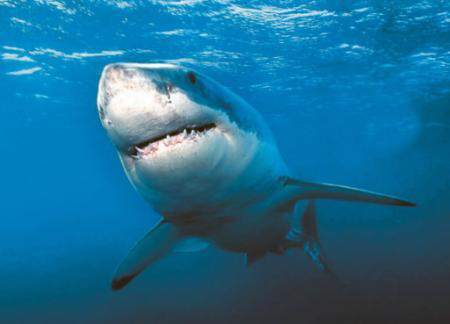

Motion Blur is 

Reference: https://github.com/hendrycks/robustness/tree/master/ImageNet-C

## Sample

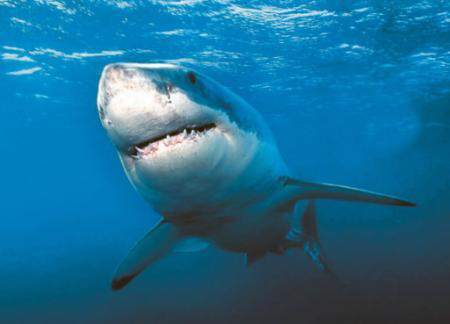

In [ ]:
# Read a sample image
img = Image.open(data_path+'pre_motion_blur_sample1.JPEG')
im = np.array(img)
input = img.convert('RGB')
img # Show Images

In [ ]:
# This function uses the MagickMotionBlurImage function of Wand library
def motion_blur(x, severity=1):
    c = [(10, 3), (15, 5), (15, 8), (15, 12), (20, 15)][severity - 1]

    output = BytesIO()
    x.save(output, format='PNG')
    x = MotionImage(blob=output.getvalue())

    x.motion_blur(radius=c[0], sigma=c[1], angle=np.random.uniform(-45, 45))

    x = cv2.cv2.imdecode(np.fromstring(x.make_blob(), np.uint8),
                     cv2.cv2.IMREAD_UNCHANGED)

    if x.shape != (224, 224):
        return np.clip(x[..., [2, 1, 0]], 0, 255)  # BGR to RGB
    else:  # greyscale to RGB
        return np.clip(np.array([x, x, x]).transpose((1, 2, 0)), 0, 255)

# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)

RGB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


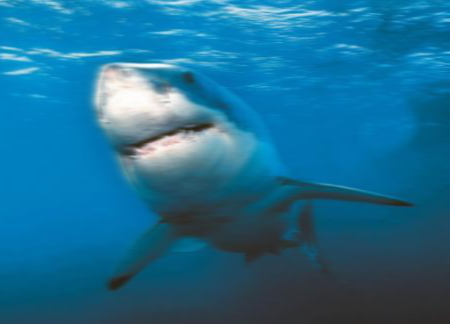

In [ ]:
im_out = motion_blur(input, 2)
pil_img = Image.fromarray(im_out)
print(pil_img.mode)# RGB
pil_img.save(data_path+'after_motion_blur_sample1_2.JPEG')
pil_img

RGB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # This is added back by InteractiveShellApp.init_path()


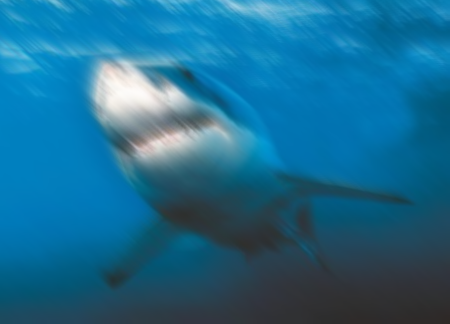

In [ ]:
im_out = motion_blur(input, 4)
pil_img = Image.fromarray(im_out)
print(pil_img.mode)# RGB
pil_img.save(data_path+'after_motion_blur_sample1_4.JPEG')
pil_img

## Actual Data Augmentation


In our experiment, we conduct the motion blur augmentation on the imagenet dataset. Using

`python make_imagenet_c_motionblur.py` to generate augmented datasets.


The output contains five folders, '1','2','3','4','5'. The numbers represent the severities of the augmentation. 


Then we use datasets after motion blur augmentation(severity = 2 and severity = 3) to train the models.

# Color Space

We have prepared augmentation methods for brightness, contrast and saturation. But because of the limited time, we only conducted experiments on contrast augmentation (severity = 2 and severity = 3).

## Sample

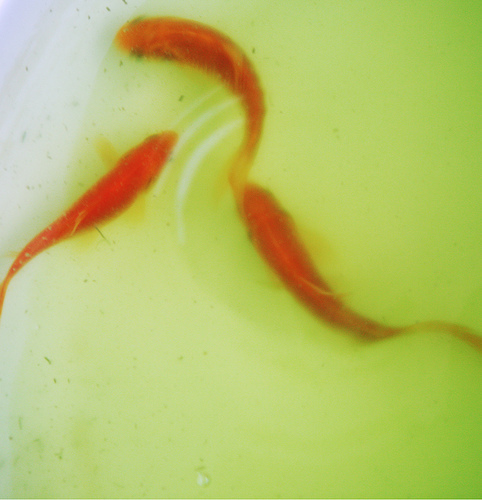

In [ ]:
# Read a sample image
img2 = Image.open(data_path+'pre_contrast_sample1.JPEG')
input2 = img2.convert('RGB')
img2 # Show Images

In [ ]:
def contrast(x, severity=1):
    c = [1.1, 1.2, 1.3, 1.4, 1.5] [severity-1]
    x = np.array(x) / 255.
    return np.clip((x - 128.0/255.0) * c + 128.0/255.0, 0, 1) * 255.

RGB


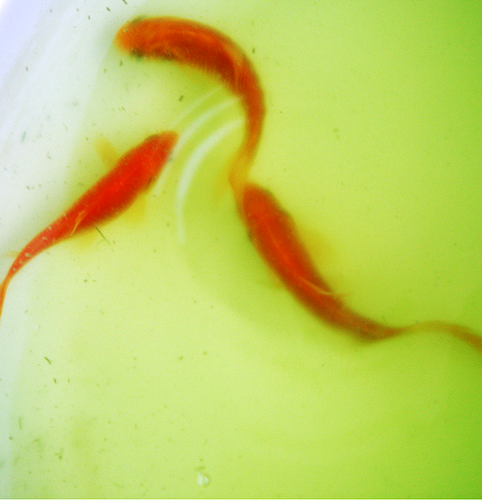

In [ ]:
im_out2 = contrast(input2, 2)
im_out2 = im_out2.astype(np.uint8)
pil_img2 = Image.fromarray(im_out2)
print(pil_img2.mode)# RGB
pil_img2.save(data_path+'after_contrast_sample1_2.JPEG')
pil_img2

RGB


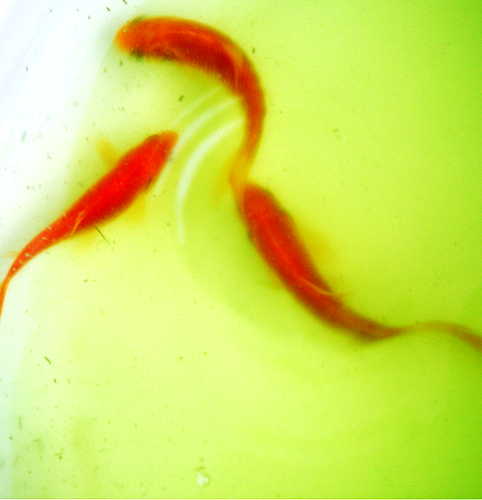

In [ ]:
im_out2 = contrast(input2, 5)
im_out2 = im_out2.astype(np.uint8)
pil_img2 = Image.fromarray(im_out2)
print(pil_img2.mode)# RGB
pil_img2.save(data_path+'after_contrast_sample1_5.JPEG')
pil_img2

## Actual Data Augmentation

In [ ]:
# /////////////// Data Loader ///////////////


IMG_EXTENSIONS = ['.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm']


def is_image_file(filename):
    """Checks if a file is an image.
    Args:
        filename (string): path to a file
    Returns:
        bool: True if the filename ends with a known image extension
    """
    filename_lower = filename.lower()
    return any(filename_lower.endswith(ext) for ext in IMG_EXTENSIONS)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(dir, class_to_idx):
    images = []
    dir = os.path.expanduser(dir)
    for target in sorted(os.listdir(dir)):
        d = os.path.join(dir, target)
        if not os.path.isdir(d):
            continue

        for root, _, fnames in sorted(os.walk(d)):
            for fname in sorted(fnames):
                if is_image_file(fname):
                    path = os.path.join(root, fname)
                    item = (path, class_to_idx[target])
                    images.append(item)
    return images


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


class DistortImageFolder(data.Dataset):
    def __init__(self, root, method, severity, transform=None, target_transform=None,
                 loader=default_loader):
        classes, class_to_idx = find_classes(root)
        imgs = make_dataset(root, class_to_idx)
        if len(imgs) == 0:
            raise (RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                                                                             "Supported image extensions are: " + ",".join(
                IMG_EXTENSIONS)))

        self.root = root
        self.method = method
        self.severity = severity
        self.imgs = imgs
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img = self.transform(img)
            img = self.method(img, self.severity)
        if self.target_transform is not None:
            target = self.target_transform(target)
        # /home/jtang/Desktop/DistortedImageNet/JPEG/
        save_path = '/data/imagenet_augment_contrast/' + self.method.__name__ + \
                    '/' + str(self.severity) + '/' + self.idx_to_class[target]

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        save_path += path[path.rindex('/'):]

        Image.fromarray(np.uint8(img)).save(save_path, quality=85, optimize=True)

        return 0  # we do not care about returning the data

    def __len__(self):
        return len(self.imgs)


# /////////////// Distortion Helpers ///////////////
warnings.simplefilter("ignore", UserWarning)




# Tell Python about the C method
wandlibrary.MagickMotionBlurImage.argtypes = (ctypes.c_void_p,  # wand
                                              ctypes.c_double,  # radius
                                              ctypes.c_double,  # sigma
                                              ctypes.c_double)  # angle


# Extend wand.image.Image class to include method signature
class MotionImage(WandImage):
    def motion_blur(self, radius=0.0, sigma=0.0, angle=0.0):
        wandlibrary.MagickMotionBlurImage(self.wand, radius, sigma, angle)



# /////////////// Distortions ///////////////

def gaussian_noise(x, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]

    x = np.array(x) / 255.
    return np.clip(x + np.random.normal(size=x.shape, scale=c), 0, 1) * 255

'''
    c = [0.4, .3, .2, .1, .05][severity - 1]
    # c = 2.0
    x = np.array(x) / 255.
    means = np.mean(x, axis=(0, 1), keepdims=True)
    return np.clip((x - means) * c + means, 0, 1) * 255.
'''
def contrast(x, severity=1):
    c = [1.1, 1.2, 1.3, 1.4, 1.5] [severity-1]
    x = np.array(x) / 255.
    return np.clip((x - 128.0/255.0) * c + 128.0/255.0, 0, 1) * 255.



# /////////////////////////////////////////////
# /data/imagenet/ILSVRC/Data/CLS-LOC/real_train
# /home/jtang/Desktop/val
def save_distorted(method=gaussian_noise):
    for severity in range(3, 4):# HERE can modify the severity of augmentation
        #severity = 0
        print(method.__name__, severity)
        distorted_dataset = DistortImageFolder(
            root="/data/imagenet/ILSVRC/Data/CLS-LOC/real_train",
            method=method, severity=severity,
            transform=trn.Compose([trn.Resize(256), trn.CenterCrop(224)]))
        distorted_dataset_loader = torch.utils.data.DataLoader(
            distorted_dataset, batch_size=100, shuffle=False, num_workers=4)

        for _ in distorted_dataset_loader: continue


# /////////////// Display Results ///////////////
import collections

print('\nUsing ImageNet data')
save_distorted(contrast)


Using ImageNet data
contrast 3



To save time of data augmentation, we only generate datasets after contrast augmentation with severity = 2 and severity = 3.

The code above is generating datasets after contrast augmentation with severity = 3. The severity can be manually modified in the `save_distorted(method=gaussian_noise)` function

# EDSR

## Sample

Since EDSR method is a complicated neural network data augmentation method, we are directly showing the images in the sample.

Reference: https://github.com/hendrycks/imagenet-r

Before EDSR:


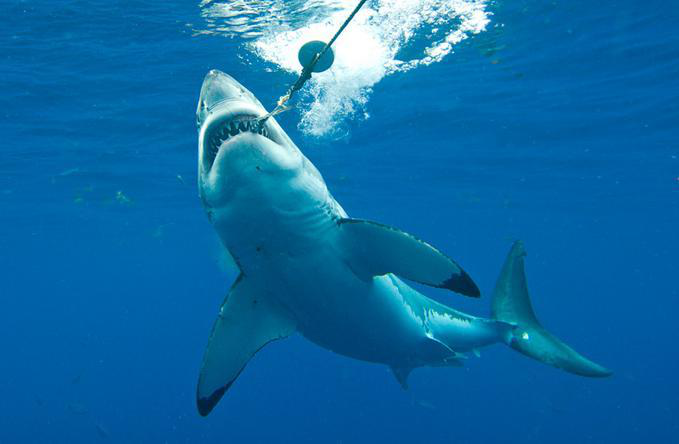

In [ ]:
print("Before EDSR:")
# Read a sample image
img3 = Image.open(data_path+'pre_EDSR_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

Before EDSR:


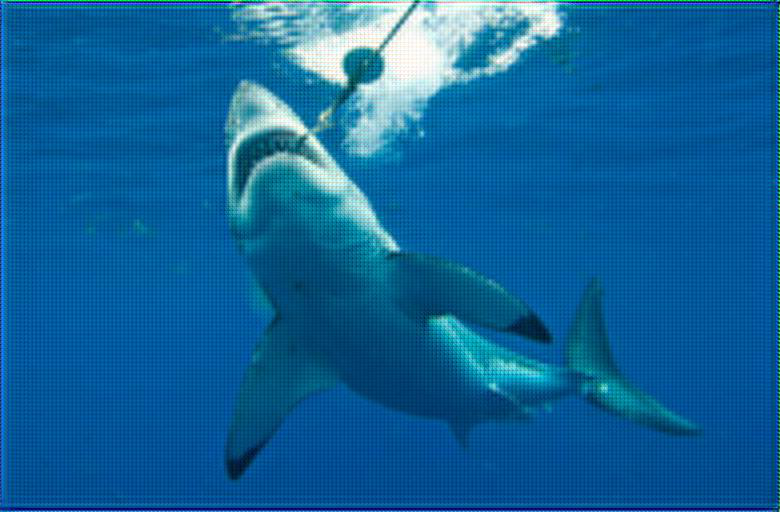

In [ ]:
print("After EDSR:")
# Read a sample image
img3 = Image.open(data_path+'after_EDSR_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

## Actual Data Augmentation

In [ ]:
import torch
#/home/jtang/robustness/imagenet-r/DeepAugment/EDSR_Model
from EDSR_Model import common
import torch.nn as nn
from torchvision import transforms as trn
from torchvision import datasets
import torchvision.transforms.functional as trnF
import numpy as np
from torch.nn.functional import gelu
from torch.nn.functional import conv2d
import torch.utils.data as data
from torchvision.datasets import ImageFolder
import sys
import os
from PIL import Image

import torch.nn.functional as F

from tqdm import tqdm

import os
import shutil
import tempfile
import random

import torchvision

import argparse

In [ ]:
total_workers = 1
worker_number = 0

all_classes = ["n01440764", "n01443537", "n01484850", "n01491361", "n01494475", "n01496331", "n01498041", "n01514668", "n01514859", "n01518878", "n01530575", "n01531178", "n01532829", "n01534433", "n01537544", "n01558993", "n01560419", "n01580077", "n01582220", "n01592084", "n01601694", "n01608432", "n01614925", "n01616318", "n01622779", "n01629819", "n01630670", "n01631663", "n01632458", "n01632777", "n01641577", "n01644373", "n01644900", "n01664065", "n01665541", "n01667114", "n01667778", "n01669191", "n01675722", "n01677366", "n01682714", "n01685808", "n01687978", "n01688243", "n01689811", "n01692333", "n01693334", "n01694178", "n01695060", "n01697457", "n01698640", "n01704323", "n01728572", "n01728920", "n01729322", "n01729977", "n01734418", "n01735189", "n01737021", "n01739381", "n01740131", "n01742172", "n01744401", "n01748264", "n01749939", "n01751748", "n01753488", "n01755581", "n01756291", "n01768244", "n01770081", "n01770393", "n01773157", "n01773549", "n01773797", "n01774384", "n01774750", "n01775062", "n01776313", "n01784675", "n01795545", "n01796340", "n01797886", "n01798484", "n01806143", "n01806567", "n01807496", "n01817953", "n01818515", "n01819313", "n01820546", "n01824575", "n01828970", "n01829413", "n01833805", "n01843065", "n01843383", "n01847000", "n01855032", "n01855672", "n01860187", "n01871265", "n01872401", "n01873310", "n01877812", "n01882714", "n01883070", "n01910747", "n01914609", "n01917289", "n01924916", "n01930112", "n01943899", "n01944390", "n01945685", "n01950731", "n01955084", "n01968897", "n01978287", "n01978455", "n01980166", "n01981276", "n01983481", "n01984695", "n01985128", "n01986214", "n01990800", "n02002556", "n02002724", "n02006656", "n02007558", "n02009229", "n02009912", "n02011460", "n02012849", "n02013706", "n02017213", "n02018207", "n02018795", "n02025239", "n02027492", "n02028035", "n02033041", "n02037110", "n02051845", "n02056570", "n02058221", "n02066245", "n02071294", "n02074367", "n02077923", "n02085620", "n02085782", "n02085936", "n02086079", "n02086240", "n02086646", "n02086910", "n02087046", "n02087394", "n02088094", "n02088238", "n02088364", "n02088466", "n02088632", "n02089078", "n02089867", "n02089973", "n02090379", "n02090622", "n02090721", "n02091032", "n02091134", "n02091244", "n02091467", "n02091635", "n02091831", "n02092002", "n02092339", "n02093256", "n02093428", "n02093647", "n02093754", "n02093859", "n02093991", "n02094114", "n02094258", "n02094433", "n02095314", "n02095570", "n02095889", "n02096051", "n02096177", "n02096294", "n02096437", "n02096585", "n02097047", "n02097130", "n02097209", "n02097298", "n02097474", "n02097658", "n02098105", "n02098286", "n02098413", "n02099267", "n02099429", "n02099601", "n02099712", "n02099849", "n02100236", "n02100583", "n02100735", "n02100877", "n02101006", "n02101388", "n02101556", "n02102040", "n02102177", "n02102318", "n02102480", "n02102973", "n02104029", "n02104365", "n02105056", "n02105162", "n02105251", "n02105412", "n02105505", "n02105641", "n02105855", "n02106030", "n02106166", "n02106382", "n02106550", "n02106662", "n02107142", "n02107312", "n02107574", "n02107683", "n02107908", "n02108000", "n02108089", "n02108422", "n02108551", "n02108915", "n02109047", "n02109525", "n02109961", "n02110063", "n02110185", "n02110341", "n02110627", "n02110806", "n02110958", "n02111129", "n02111277", "n02111500", "n02111889", "n02112018", "n02112137", "n02112350", "n02112706", "n02113023", "n02113186", "n02113624", "n02113712", "n02113799", "n02113978", "n02114367", "n02114548", "n02114712", "n02114855", "n02115641", "n02115913", "n02116738", "n02117135", "n02119022", "n02119789", "n02120079", "n02120505", "n02123045", "n02123159", "n02123394", "n02123597", "n02124075", "n02125311", "n02127052", "n02128385", "n02128757", "n02128925", "n02129165", "n02129604", "n02130308", "n02132136", "n02133161", "n02134084", "n02134418", "n02137549", "n02138441", "n02165105", "n02165456", "n02167151", "n02168699", "n02169497", "n02172182", "n02174001", "n02177972", "n02190166", "n02206856", "n02219486", "n02226429", "n02229544", "n02231487", "n02233338", "n02236044", "n02256656", "n02259212", "n02264363", "n02268443", "n02268853", "n02276258", "n02277742", "n02279972", "n02280649", "n02281406", "n02281787", "n02317335", "n02319095", "n02321529", "n02325366", "n02326432", "n02328150", "n02342885", "n02346627", "n02356798", "n02361337", "n02363005", "n02364673", "n02389026", "n02391049", "n02395406", "n02396427", "n02397096", "n02398521", "n02403003", "n02408429", "n02410509", "n02412080", "n02415577", "n02417914", "n02422106", "n02422699", "n02423022", "n02437312", "n02437616", "n02441942", "n02442845", "n02443114", "n02443484", "n02444819", "n02445715", "n02447366", "n02454379", "n02457408", "n02480495", "n02480855", "n02481823", "n02483362", "n02483708", "n02484975", "n02486261", "n02486410", "n02487347", "n02488291", "n02488702", "n02489166", "n02490219", "n02492035", "n02492660", "n02493509", "n02493793", "n02494079", "n02497673", "n02500267", "n02504013", "n02504458", "n02509815", "n02510455", "n02514041", "n02526121", "n02536864", "n02606052", "n02607072", "n02640242", "n02641379", "n02643566", "n02655020", "n02666196", "n02667093", "n02669723", "n02672831", "n02676566", "n02687172", "n02690373", "n02692877", "n02699494", "n02701002", "n02704792", "n02708093", "n02727426", "n02730930", "n02747177", "n02749479", "n02769748", "n02776631", "n02777292", "n02782093", "n02783161", "n02786058", "n02787622", "n02788148", "n02790996", "n02791124", "n02791270", "n02793495", "n02794156", "n02795169", "n02797295", "n02799071", "n02802426", "n02804414", "n02804610", "n02807133", "n02808304", "n02808440", "n02814533", "n02814860", "n02815834", "n02817516", "n02823428", "n02823750", "n02825657", "n02834397", "n02835271", "n02837789", "n02840245", "n02841315", "n02843684", "n02859443", "n02860847", "n02865351", "n02869837", "n02870880", "n02871525", "n02877765", "n02879718", "n02883205", "n02892201", "n02892767", "n02894605", "n02895154", "n02906734", "n02909870", "n02910353", "n02916936", "n02917067", "n02927161", "n02930766", "n02939185", "n02948072", "n02950826", "n02951358", "n02951585", "n02963159", "n02965783", "n02966193", "n02966687", "n02971356", "n02974003", "n02977058", "n02978881", "n02979186", "n02980441", "n02981792", "n02988304", "n02992211", "n02992529", "n02999410", "n03000134", "n03000247", "n03000684", "n03014705", "n03016953", "n03017168", "n03018349", "n03026506", "n03028079", "n03032252", "n03041632", "n03042490", "n03045698", "n03047690", "n03062245", "n03063599", "n03063689", "n03065424", "n03075370", "n03085013", "n03089624", "n03095699", "n03100240", "n03109150", "n03110669", "n03124043", "n03124170", "n03125729", "n03126707", "n03127747", "n03127925", "n03131574", "n03133878", "n03134739", "n03141823", "n03146219", "n03160309", "n03179701", "n03180011", "n03187595", "n03188531", "n03196217", "n03197337", "n03201208", "n03207743", "n03207941", "n03208938", "n03216828", "n03218198", "n03220513", "n03223299", "n03240683", "n03249569", "n03250847", "n03255030", "n03259280", "n03271574", "n03272010", "n03272562", "n03290653", "n03291819", "n03297495", "n03314780", "n03325584", "n03337140", "n03344393", "n03345487", "n03347037", "n03355925", "n03372029", "n03376595", "n03379051", "n03384352", "n03388043", "n03388183", "n03388549", "n03393912", "n03394916", "n03400231", "n03404251", "n03417042", "n03424325", "n03425413", "n03443371", "n03444034", "n03445777", "n03445924", "n03447447", "n03447721", "n03450230", "n03452741", "n03457902", "n03459775", "n03461385", "n03467068", "n03476684", "n03476991", "n03478589", "n03481172", "n03482405", "n03483316", "n03485407", "n03485794", "n03492542", "n03494278", "n03495258", "n03496892", "n03498962", "n03527444", "n03529860", "n03530642", "n03532672", "n03534580", "n03535780", "n03538406", "n03544143", "n03584254", "n03584829", "n03590841", "n03594734", "n03594945", "n03595614", "n03598930", "n03599486", "n03602883", "n03617480", "n03623198", "n03627232", "n03630383", "n03633091", "n03637318", "n03642806", "n03649909", "n03657121", "n03658185", "n03661043", "n03662601", "n03666591", "n03670208", "n03673027", "n03676483", "n03680355", "n03690938", "n03691459", "n03692522", "n03697007", "n03706229", "n03709823", "n03710193", "n03710637", "n03710721", "n03717622", "n03720891", "n03721384", "n03724870", "n03729826", "n03733131", "n03733281", "n03733805", "n03742115", "n03743016", "n03759954", "n03761084", "n03763968", "n03764736", "n03769881", "n03770439", "n03770679", "n03773504", "n03775071", "n03775546", "n03776460", "n03777568", "n03777754", "n03781244", "n03782006", "n03785016", "n03786901", "n03787032", "n03788195", "n03788365", "n03791053", "n03792782", "n03792972", "n03793489", "n03794056", "n03796401", "n03803284", "n03804744", "n03814639", "n03814906", "n03825788", "n03832673", "n03837869", "n03838899", "n03840681", "n03841143", "n03843555", "n03854065", "n03857828", "n03866082", "n03868242", "n03868863", "n03871628", "n03873416", "n03874293", "n03874599", "n03876231", "n03877472", "n03877845", "n03884397", "n03887697", "n03888257", "n03888605", "n03891251", "n03891332", "n03895866", "n03899768", "n03902125", "n03903868", "n03908618", "n03908714", "n03916031", "n03920288", "n03924679", "n03929660", "n03929855", "n03930313", "n03930630", "n03933933", "n03935335", "n03937543", "n03938244", "n03942813", "n03944341", "n03947888", "n03950228", "n03954731", "n03956157", "n03958227", "n03961711", "n03967562", "n03970156", "n03976467", "n03976657", "n03977966", "n03980874", "n03982430", "n03983396", "n03991062", "n03992509", "n03995372", "n03998194", "n04004767", "n04005630", "n04008634", "n04009552", "n04019541", "n04023962", "n04026417", "n04033901", "n04033995", "n04037443", "n04039381", "n04040759", "n04041544", "n04044716", "n04049303", "n04065272", "n04067472", "n04069434", "n04070727", "n04074963", "n04081281", "n04086273", "n04090263", "n04099969", "n04111531", "n04116512", "n04118538", "n04118776", "n04120489", "n04125021", "n04127249", "n04131690", "n04133789", "n04136333", "n04141076", "n04141327", "n04141975", "n04146614", "n04147183", "n04149813", "n04152593", "n04153751", "n04154565", "n04162706", "n04179913", "n04192698", "n04200800", "n04201297", "n04204238", "n04204347", "n04208210", "n04209133", "n04209239", "n04228054", "n04229816", "n04235860", "n04238763", "n04239074", "n04243546", "n04251144", "n04252077", "n04252225", "n04254120", "n04254680", "n04254777", "n04258138", "n04259630", "n04263257", "n04264628", "n04265275", "n04266014", "n04270147", "n04273569", "n04275548", "n04277352", "n04285008", "n04286575", "n04296562", "n04310018", "n04311004", "n04311174", "n04317175", "n04325704", "n04326547", "n04328186", "n04330267", "n04332243", "n04335435", "n04336792", "n04344873", "n04346328", "n04347754", "n04350905", "n04355338", "n04355933", "n04356056", "n04357314", "n04366367", "n04367480", "n04370456", "n04371430", "n04371774", "n04372370", "n04376876", "n04380533", "n04389033", "n04392985", "n04398044", "n04399382", "n04404412", "n04409515", "n04417672", "n04418357", "n04423845", "n04428191", "n04429376", "n04435653", "n04442312", "n04443257", "n04447861", "n04456115", "n04458633", "n04461696", "n04462240", "n04465501", "n04467665", "n04476259", "n04479046", "n04482393", "n04483307", "n04485082", "n04486054", "n04487081", "n04487394", "n04493381", "n04501370", "n04505470", "n04507155", "n04509417", "n04515003", "n04517823", "n04522168", "n04523525", "n04525038", "n04525305", "n04532106", "n04532670", "n04536866", "n04540053", "n04542943", "n04548280", "n04548362", "n04550184", "n04552348", "n04553703", "n04554684", "n04557648", "n04560804", "n04562935", "n04579145", "n04579432", "n04584207", "n04589890", "n04590129", "n04591157", "n04591713", "n04592741", "n04596742", "n04597913", "n04599235", "n04604644", "n04606251", "n04612504", "n04613696", "n06359193", "n06596364", "n06785654", "n06794110", "n06874185", "n07248320", "n07565083", "n07579787", "n07583066", "n07584110", "n07590611", "n07613480", "n07614500", "n07615774", "n07684084", "n07693725", "n07695742", "n07697313", "n07697537", "n07711569", "n07714571", "n07714990", "n07715103", "n07716358", "n07716906", "n07717410", "n07717556", "n07718472", "n07718747", "n07720875", "n07730033", "n07734744", "n07742313", "n07745940", "n07747607", "n07749582", "n07753113", "n07753275", "n07753592", "n07754684", "n07760859", "n07768694", "n07802026", "n07831146", "n07836838", "n07860988", "n07871810", "n07873807", "n07875152", "n07880968", "n07892512", "n07920052", "n07930864", "n07932039", "n09193705", "n09229709", "n09246464", "n09256479", "n09288635", "n09332890", "n09399592", "n09421951", "n09428293", "n09468604", "n09472597", "n09835506", "n10148035", "n10565667", "n11879895", "n11939491", "n12057211", "n12144580", "n12267677", "n12620546", "n12768682", "n12985857", "n12998815", "n13037406", "n13040303", "n13044778", "n13052670", "n13054560", "n13133613", "n15075141"]
all_classes.sort()
assert len(all_classes) == 1000

# Subset for this worker
classes_chosen = np.array_split(all_classes, total_workers)[worker_number]

class ImageNetSubsetDataset(torchvision.datasets.ImageFolder):
    """
    Dataset class to take a specified subset of some larger dataset
    """
    def __init__(self, root, *args, **kwargs):

        print("Using {0} classes {1}".format(len(classes_chosen), classes_chosen))

        self.new_root = tempfile.mkdtemp()
        for _class in classes_chosen:
            orig_dir = os.path.join(root, _class)
            #assert os.path.isdir(orig_dir)

            os.symlink(orig_dir, os.path.join(self.new_root, _class))

        super().__init__(self.new_root, *args, **kwargs)

        return self.new_root

    def __del__(self):
        # Clean up
        shutil.rmtree(self.new_root)


# test_transform = lambda x: trnF.to_tensor(trnF.resize(x, 128))
test_transform = trn.Compose([trn.Resize(128), trn.ToTensor()])


def make_model(args, parent=False):
    return EDSR(args)

class EDSR(nn.Module):
    def __init__(self,
                 n_resblocks=16, n_feats=64, scale=4, res_scale=1, rgb_range=255, n_colors=3,
                 conv=common.default_conv):
        super(EDSR, self).__init__()

        kernel_size = 3
        act = nn.ReLU(True)
        url_name = 'r{}f{}x{}'.format(n_resblocks, n_feats, scale)
        self.sub_mean = common.MeanShift(rgb_range)
        self.add_mean = common.MeanShift(rgb_range, sign=1)

        # define head module
        m_head = [conv(n_colors, n_feats, kernel_size)]

        # define body module
        m_body = [
            common.ResBlock(
                conv, n_feats, kernel_size, act=act, res_scale=res_scale
            ) for _ in range(n_resblocks)
        ]
        m_body.append(conv(n_feats, n_feats, kernel_size))

        # define tail module
        m_tail = [
            common.Upsampler(conv, scale, n_feats, act=False),
            conv(n_feats, n_colors, kernel_size)
        ]

        self.head = nn.Sequential(*m_head)
        self.body = nn.Sequential(*m_body)
        self.tail = nn.Sequential(*m_tail)

    def forward(self, x, pre_distortions={None}, body_distortions={None}):
        # print("Using FF pre distortions = ", pre_distortions)
        # print("Using FF body distortions = ", body_distortions)
        x = self.sub_mean(x)
        x = self.head(x)

        ######################################################################
        # PRE - DISTORTIONS
        ######################################################################

        if 1 in pre_distortions:
            for _ in range(5):
                c1, c2 = random.randint(0, 63), random.randint(0, 63)
                x[:, c1], x[:, c2] = x[:, c2], x[:, c1]

        if 2 in pre_distortions:
            rand_filter_weight = torch.round(torch.rand_like(x) + 0.45) # Random matrix of 1s and 0s
            x = x * rand_filter_weight

        if 3 in pre_distortions:
            rand_filter_weight = (torch.round(torch.rand_like(x) + 0.475) * 2) - 1 # Random matrix of 1s and -1s
            x = x * rand_filter_weight

        ######################################################################
        # BODY - DISTORTIONS
        ######################################################################

        if 1 in body_distortions:
            res = self.body[:5](x)
            res = -res
            res = self.body[5:](res)
        elif 2 in body_distortions:
            if random.randint(0, 2) == 1:
                act = F.relu
            else:
                act = F.gelu
            res = self.body[:5](x)
            res = act(res)
            res = self.body[5:](res)
        elif 3 in body_distortions:
            if random.randint(0, 2) == 1:
                axes = [1, 2]
            else:
                axes = [1, 3]
            res = self.body[:5](x)
            res = torch.flip(res, axes)
            res = self.body[5:](res)
        elif 4 in body_distortions:
            to_skip = set([random.randint(2, 16) for _ in range(3)])
            for i in range(len(self.body)):
                if i not in to_skip:
                    res = self.body[i](x)
        else:
            res = self.body(x)

        res += x

        x = self.tail(res)
        x = self.add_mean(x)

        return x

def get_weights():
    weights = torch.load('./EDSR_Weights/edsr_baseline_x4.pt')

    random_sample_list = np.random.randint(0,17, size=3)
    for option in list(random_sample_list):
        if option == 0:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = torch.flip(weights['body.'+str(i)+'.body.0.weight'], (0,))
            weights['body.'+str(i)+'.body.0.bias'] = torch.flip(weights['body.'+str(i)+'.body.0.bias'], (0,))
            weights['body.'+str(i)+'.body.2.weight'] = torch.flip(weights['body.'+str(i)+'.body.2.weight'], (0,))
            weights['body.'+str(i)+'.body.2.bias'] = torch.flip(weights['body.'+str(i)+'.body.2.bias'], (0,))
        elif option == 1:
            i = np.random.choice(np.arange(1,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = -weights['body.'+str(i)+'.body.0.weight']
            weights['body.'+str(i)+'.body.0.bias'] = -weights['body.'+str(i)+'.body.0.bias']
        elif option == 2:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = 0 * weights['body.'+str(i)+'.body.0.weight']
            weights['body.'+str(i)+'.body.0.bias'] = 0*weights['body.'+str(i)+'.body.0.bias']
        elif option == 3:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = -gelu(weights['body.'+str(i)+'.body.0.weight'])
            weights['body.'+str(i)+'.body.2.weight'] = -gelu(weights['body.'+str(i)+'.body.2.weight'])
        elif option == 4:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] *\
            torch.Tensor([[0, 1, 0],[1, -4., 1], [0, 1, 0]]).view(1,1,3,3).cuda()
        elif option == 5:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] *\
            torch.Tensor([[-1, -1, -1],[-1, 8., -1], [-1, -1, -1]]).view(1,1,3,3).cuda()
        elif option == 6:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.2.weight'] = weights['body.'+str(i)+'.body.2.weight'] *\
            (1 + 2 * np.float32(np.random.uniform()) * (2*torch.rand_like(weights['body.'+str(i)+'.body.2.weight']-1)))
        elif option == 7:
            i = np.random.choice(np.arange(0,10,3))
            weights['body.'+str(i)+'.body.0.weight'] = torch.flip(weights['body.'+str(i)+'.body.0.weight'], (-1,))
            weights['body.'+str(i)+'.body.2.weight'] = -1 * weights['body.'+str(i)+'.body.2.weight']
        elif option == 8:
            i = np.random.choice(np.arange(1,13,4))
            z = torch.zeros_like(weights['body.'+str(i)+'.body.0.weight'])
            for j in range(z.size(0)):
                shift_x, shift_y = np.random.randint(3, size=(2,))
                z[:,j,shift_x,shift_y] = np.random.choice([1.,-1.])
            weights['body.'+str(i)+'.body.0.weight'] = conv2d(weights['body.'+str(i)+'.body.0.weight'], z, padding=1)
        elif option == 9:
            i = np.random.choice(np.arange(0,10,3))
            z = (2*torch.rand_like(weights['body.'+str(i)+'.body.0.weight'])*np.float32(np.random.uniform()) - 1)/6.
            weights['body.'+str(i)+'.body.0.weight'] = conv2d(weights['body.'+str(i)+'.body.0.weight'], z, padding=1)
        elif option == 10:
            i = np.random.choice(np.arange(1,12,4))
            z = torch.FloatTensor(np.random.dirichlet([0.1] * 9, (64,64))).view(64,64,3,3).cuda() # 2.weight
            weights['body.'+str(i)+'.body.2.weight'] = conv2d(weights['body.'+str(i)+'.body.2.weight'], z, padding=1)
        elif option == 11: ############ Start Saurav's changes ############
            i = random.choice(list(range(15)))
            noise = (torch.rand_like(weights['body.'+str(i)+'.body.2.weight']) - 0.5) * 1.0
            weights['body.'+str(i)+'.body.2.weight'] += noise
        elif option == 12:
            _ij = [[random.choice(list(range(15))), random.choice([0, 2])] for _ in range(5)]
            for i, j in _ij:
                _k = random.randint(1, 3)
                if random.randint(0, 1) == 0:
                    _dims = (2,3)
                else:
                    _dims = (0,1)
                weights['body.'+str(i)+'.body.'+str(j)+'.weight'] = torch.rot90(weights['body.'+str(i)+'.body.'+str(j)+'.weight'], k=_k, dims=_dims)
        elif option == 13:
            _i = [random.choice(list(range(15))) for _ in range(5)]
            for i in _i:
                rand_filter_weight = torch.round(torch.rand_like(weights['body.'+str(i)+'.body.0.weight'])) * 2 - 1 # Random matrix of 1s and -1s
                weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] * rand_filter_weight
        elif option == 14:
            # Barely noticable difference here
            _i = [random.choice(list(range(15))) for _ in range(5)]
            for i in _i:
                rand_filter_weight = torch.round(torch.rand_like(weights['body.'+str(i)+'.body.0.weight'])) # Random matrix of 1s and 0s
                weights['body.'+str(i)+'.body.0.weight'] = weights['body.'+str(i)+'.body.0.weight'] * rand_filter_weight
        elif option == 15:
            # Negate some entire filters. Definitely a noticable difference
            _i = [random.choice(list(range(15))) for _ in range(5)]
            for i in _i:
                filters_to_be_zeroed = [random.choice(list(range(64))) for _ in range(32)]
                weights['body.'+str(i)+'.body.0.weight'][filters_to_be_zeroed] *= -1
        elif option == 16:
            # Only keep the max filter value in the conv
            _ij = [[random.choice(list(range(15))), random.choice([0, 2])] for _ in range(5)]
            for i, j in _ij:
                w = torch.reshape(weights['body.'+str(i)+'.body.'+str(j)+'.weight'], shape=(64, 64, 9))
                res = torch.topk(w, k=1)

                w_new = torch.zeros_like(w).scatter(2, res.indices, res.values)
                w_new = w_new.reshape(64, 64, 3, 3)
                weights['body.'+str(i)+'.body.'+str(j)+'.weight'] = w_new
        else:
            raise NotImplementedError()
    return weights

weights = get_weights()

net = EDSR()
net.load_state_dict(weights)
net.cuda()
net.eval()


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


class FolderWithPath(ImageNetSubsetDataset):
    def __init__(self, root, transform, **kwargs):
        new_root = super(FolderWithPath, self).__init__(root, transform=transform)

        classes, class_to_idx = find_classes(new_root)
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # save_path = '~/data/hendrycks/DistortedImageNet/' + str(self.option) + '/' + self.idx_to_class[target]
        save_path = '/data/imagenet_augment_EDSR/' + self.idx_to_class[target]

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        save_path += path[path.rindex('/'):]

        if np.random.uniform() < 0.05:
            weights = get_weights()
            net.load_state_dict(weights)
        with torch.no_grad():
            pre_dist = set([random.randint(1, 4) for _ in range(1)])
            body_dist = set([random.randint(1, 5)])
            img = trnF.to_pil_image(net(255*sample.unsqueeze(0).cuda(), pre_distortions=pre_dist, body_distortions=body_dist).squeeze().to('cpu').clamp(0, 255)/255.)

        img.save(save_path)

        return 0


distorted_dataset = FolderWithPath(
    root="/data/imagenet/ILSVRC/Data/CLS-LOC/real_train", transform=test_transform)

distorted_dataset[0]

loader = torch.utils.data.DataLoader(
  distorted_dataset, batch_size=16, shuffle=True)

for _ in tqdm(loader): continue


Using 1000 classes ['n01440764' 'n01443537' 'n01484850' 'n01491361' 'n01494475' 'n01496331'
 'n01498041' 'n01514668' 'n01514859' 'n01518878' 'n01530575' 'n01531178'
 'n01532829' 'n01534433' 'n01537544' 'n01558993' 'n01560419' 'n01580077'
 'n01582220' 'n01592084' 'n01601694' 'n01608432' 'n01614925' 'n01616318'
 'n01622779' 'n01629819' 'n01630670' 'n01631663' 'n01632458' 'n01632777'
 'n01641577' 'n01644373' 'n01644900' 'n01664065' 'n01665541' 'n01667114'
 'n01667778' 'n01669191' 'n01675722' 'n01677366' 'n01682714' 'n01685808'
 'n01687978' 'n01688243' 'n01689811' 'n01692333' 'n01693334' 'n01694178'
 'n01695060' 'n01697457' 'n01698640' 'n01704323' 'n01728572' 'n01728920'
 'n01729322' 'n01729977' 'n01734418' 'n01735189' 'n01737021' 'n01739381'
 'n01740131' 'n01742172' 'n01744401' 'n01748264' 'n01749939' 'n01751748'
 'n01753488' 'n01755581' 'n01756291' 'n01768244' 'n01770081' 'n01770393'
 'n01773157' 'n01773549' 'n01773797' 'n01774384' 'n01774750' 'n01775062'
 'n01776313' 'n01784675' 'n01795

100%|██████████| 8011/8011 [1:43:18<00:00,  1.29it/s]


# CAE

## Samples

Same as EDSR, since CAE method is a complicated neural network data augmentation method, we are directly showing the images in the sample.

Reference: https://github.com/hendrycks/imagenet-r

Before CAE:


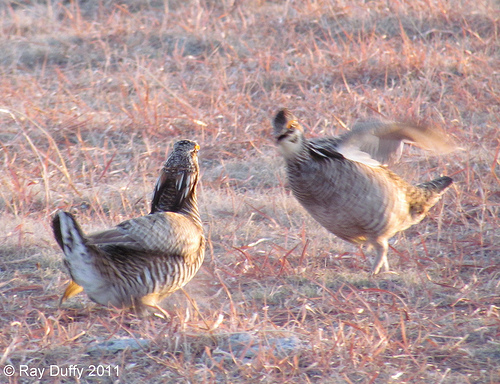

In [ ]:
print("Before CAE:")
# Read a sample image
img3 = Image.open(data_path+'pre_CAE_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

After CAE:


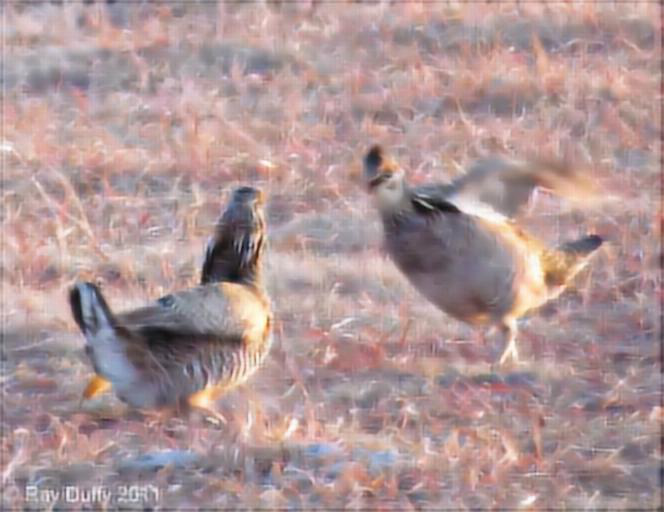

In [ ]:
print("After CAE:")
# Read a sample image
img3 = Image.open(data_path+'after_CAE_sample1.JPEG')
input3 = img3.convert('RGB')
img3 # Show Images

## Actual Data Augmentation

In [ ]:
import sys
import os
import numpy as np
import os
import shutil
import tempfile
from PIL import Image
import random
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms as trn
from torchvision import datasets
import torchvision.transforms.functional as trnF 
from torch.nn.functional import gelu, conv2d
import torch.nn.functional as F
import random
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from tqdm import tqdm

from CAE_Model.cae_32x32x32_zero_pad_bin import CAE

In [ ]:
total_workers = 1
worker_number = 0

all_classes = ["n01440764", "n01443537", "n01484850", "n01491361", "n01494475", "n01496331", "n01498041", "n01514668", "n01514859", "n01518878", "n01530575", "n01531178", "n01532829", "n01534433", "n01537544", "n01558993", "n01560419", "n01580077", "n01582220", "n01592084", "n01601694", "n01608432", "n01614925", "n01616318", "n01622779", "n01629819", "n01630670", "n01631663", "n01632458", "n01632777", "n01641577", "n01644373", "n01644900", "n01664065", "n01665541", "n01667114", "n01667778", "n01669191", "n01675722", "n01677366", "n01682714", "n01685808", "n01687978", "n01688243", "n01689811", "n01692333", "n01693334", "n01694178", "n01695060", "n01697457", "n01698640", "n01704323", "n01728572", "n01728920", "n01729322", "n01729977", "n01734418", "n01735189", "n01737021", "n01739381", "n01740131", "n01742172", "n01744401", "n01748264", "n01749939", "n01751748", "n01753488", "n01755581", "n01756291", "n01768244", "n01770081", "n01770393", "n01773157", "n01773549", "n01773797", "n01774384", "n01774750", "n01775062", "n01776313", "n01784675", "n01795545", "n01796340", "n01797886", "n01798484", "n01806143", "n01806567", "n01807496", "n01817953", "n01818515", "n01819313", "n01820546", "n01824575", "n01828970", "n01829413", "n01833805", "n01843065", "n01843383", "n01847000", "n01855032", "n01855672", "n01860187", "n01871265", "n01872401", "n01873310", "n01877812", "n01882714", "n01883070", "n01910747", "n01914609", "n01917289", "n01924916", "n01930112", "n01943899", "n01944390", "n01945685", "n01950731", "n01955084", "n01968897", "n01978287", "n01978455", "n01980166", "n01981276", "n01983481", "n01984695", "n01985128", "n01986214", "n01990800", "n02002556", "n02002724", "n02006656", "n02007558", "n02009229", "n02009912", "n02011460", "n02012849", "n02013706", "n02017213", "n02018207", "n02018795", "n02025239", "n02027492", "n02028035", "n02033041", "n02037110", "n02051845", "n02056570", "n02058221", "n02066245", "n02071294", "n02074367", "n02077923", "n02085620", "n02085782", "n02085936", "n02086079", "n02086240", "n02086646", "n02086910", "n02087046", "n02087394", "n02088094", "n02088238", "n02088364", "n02088466", "n02088632", "n02089078", "n02089867", "n02089973", "n02090379", "n02090622", "n02090721", "n02091032", "n02091134", "n02091244", "n02091467", "n02091635", "n02091831", "n02092002", "n02092339", "n02093256", "n02093428", "n02093647", "n02093754", "n02093859", "n02093991", "n02094114", "n02094258", "n02094433", "n02095314", "n02095570", "n02095889", "n02096051", "n02096177", "n02096294", "n02096437", "n02096585", "n02097047", "n02097130", "n02097209", "n02097298", "n02097474", "n02097658", "n02098105", "n02098286", "n02098413", "n02099267", "n02099429", "n02099601", "n02099712", "n02099849", "n02100236", "n02100583", "n02100735", "n02100877", "n02101006", "n02101388", "n02101556", "n02102040", "n02102177", "n02102318", "n02102480", "n02102973", "n02104029", "n02104365", "n02105056", "n02105162", "n02105251", "n02105412", "n02105505", "n02105641", "n02105855", "n02106030", "n02106166", "n02106382", "n02106550", "n02106662", "n02107142", "n02107312", "n02107574", "n02107683", "n02107908", "n02108000", "n02108089", "n02108422", "n02108551", "n02108915", "n02109047", "n02109525", "n02109961", "n02110063", "n02110185", "n02110341", "n02110627", "n02110806", "n02110958", "n02111129", "n02111277", "n02111500", "n02111889", "n02112018", "n02112137", "n02112350", "n02112706", "n02113023", "n02113186", "n02113624", "n02113712", "n02113799", "n02113978", "n02114367", "n02114548", "n02114712", "n02114855", "n02115641", "n02115913", "n02116738", "n02117135", "n02119022", "n02119789", "n02120079", "n02120505", "n02123045", "n02123159", "n02123394", "n02123597", "n02124075", "n02125311", "n02127052", "n02128385", "n02128757", "n02128925", "n02129165", "n02129604", "n02130308", "n02132136", "n02133161", "n02134084", "n02134418", "n02137549", "n02138441", "n02165105", "n02165456", "n02167151", "n02168699", "n02169497", "n02172182", "n02174001", "n02177972", "n02190166", "n02206856", "n02219486", "n02226429", "n02229544", "n02231487", "n02233338", "n02236044", "n02256656", "n02259212", "n02264363", "n02268443", "n02268853", "n02276258", "n02277742", "n02279972", "n02280649", "n02281406", "n02281787", "n02317335", "n02319095", "n02321529", "n02325366", "n02326432", "n02328150", "n02342885", "n02346627", "n02356798", "n02361337", "n02363005", "n02364673", "n02389026", "n02391049", "n02395406", "n02396427", "n02397096", "n02398521", "n02403003", "n02408429", "n02410509", "n02412080", "n02415577", "n02417914", "n02422106", "n02422699", "n02423022", "n02437312", "n02437616", "n02441942", "n02442845", "n02443114", "n02443484", "n02444819", "n02445715", "n02447366", "n02454379", "n02457408", "n02480495", "n02480855", "n02481823", "n02483362", "n02483708", "n02484975", "n02486261", "n02486410", "n02487347", "n02488291", "n02488702", "n02489166", "n02490219", "n02492035", "n02492660", "n02493509", "n02493793", "n02494079", "n02497673", "n02500267", "n02504013", "n02504458", "n02509815", "n02510455", "n02514041", "n02526121", "n02536864", "n02606052", "n02607072", "n02640242", "n02641379", "n02643566", "n02655020", "n02666196", "n02667093", "n02669723", "n02672831", "n02676566", "n02687172", "n02690373", "n02692877", "n02699494", "n02701002", "n02704792", "n02708093", "n02727426", "n02730930", "n02747177", "n02749479", "n02769748", "n02776631", "n02777292", "n02782093", "n02783161", "n02786058", "n02787622", "n02788148", "n02790996", "n02791124", "n02791270", "n02793495", "n02794156", "n02795169", "n02797295", "n02799071", "n02802426", "n02804414", "n02804610", "n02807133", "n02808304", "n02808440", "n02814533", "n02814860", "n02815834", "n02817516", "n02823428", "n02823750", "n02825657", "n02834397", "n02835271", "n02837789", "n02840245", "n02841315", "n02843684", "n02859443", "n02860847", "n02865351", "n02869837", "n02870880", "n02871525", "n02877765", "n02879718", "n02883205", "n02892201", "n02892767", "n02894605", "n02895154", "n02906734", "n02909870", "n02910353", "n02916936", "n02917067", "n02927161", "n02930766", "n02939185", "n02948072", "n02950826", "n02951358", "n02951585", "n02963159", "n02965783", "n02966193", "n02966687", "n02971356", "n02974003", "n02977058", "n02978881", "n02979186", "n02980441", "n02981792", "n02988304", "n02992211", "n02992529", "n02999410", "n03000134", "n03000247", "n03000684", "n03014705", "n03016953", "n03017168", "n03018349", "n03026506", "n03028079", "n03032252", "n03041632", "n03042490", "n03045698", "n03047690", "n03062245", "n03063599", "n03063689", "n03065424", "n03075370", "n03085013", "n03089624", "n03095699", "n03100240", "n03109150", "n03110669", "n03124043", "n03124170", "n03125729", "n03126707", "n03127747", "n03127925", "n03131574", "n03133878", "n03134739", "n03141823", "n03146219", "n03160309", "n03179701", "n03180011", "n03187595", "n03188531", "n03196217", "n03197337", "n03201208", "n03207743", "n03207941", "n03208938", "n03216828", "n03218198", "n03220513", "n03223299", "n03240683", "n03249569", "n03250847", "n03255030", "n03259280", "n03271574", "n03272010", "n03272562", "n03290653", "n03291819", "n03297495", "n03314780", "n03325584", "n03337140", "n03344393", "n03345487", "n03347037", "n03355925", "n03372029", "n03376595", "n03379051", "n03384352", "n03388043", "n03388183", "n03388549", "n03393912", "n03394916", "n03400231", "n03404251", "n03417042", "n03424325", "n03425413", "n03443371", "n03444034", "n03445777", "n03445924", "n03447447", "n03447721", "n03450230", "n03452741", "n03457902", "n03459775", "n03461385", "n03467068", "n03476684", "n03476991", "n03478589", "n03481172", "n03482405", "n03483316", "n03485407", "n03485794", "n03492542", "n03494278", "n03495258", "n03496892", "n03498962", "n03527444", "n03529860", "n03530642", "n03532672", "n03534580", "n03535780", "n03538406", "n03544143", "n03584254", "n03584829", "n03590841", "n03594734", "n03594945", "n03595614", "n03598930", "n03599486", "n03602883", "n03617480", "n03623198", "n03627232", "n03630383", "n03633091", "n03637318", "n03642806", "n03649909", "n03657121", "n03658185", "n03661043", "n03662601", "n03666591", "n03670208", "n03673027", "n03676483", "n03680355", "n03690938", "n03691459", "n03692522", "n03697007", "n03706229", "n03709823", "n03710193", "n03710637", "n03710721", "n03717622", "n03720891", "n03721384", "n03724870", "n03729826", "n03733131", "n03733281", "n03733805", "n03742115", "n03743016", "n03759954", "n03761084", "n03763968", "n03764736", "n03769881", "n03770439", "n03770679", "n03773504", "n03775071", "n03775546", "n03776460", "n03777568", "n03777754", "n03781244", "n03782006", "n03785016", "n03786901", "n03787032", "n03788195", "n03788365", "n03791053", "n03792782", "n03792972", "n03793489", "n03794056", "n03796401", "n03803284", "n03804744", "n03814639", "n03814906", "n03825788", "n03832673", "n03837869", "n03838899", "n03840681", "n03841143", "n03843555", "n03854065", "n03857828", "n03866082", "n03868242", "n03868863", "n03871628", "n03873416", "n03874293", "n03874599", "n03876231", "n03877472", "n03877845", "n03884397", "n03887697", "n03888257", "n03888605", "n03891251", "n03891332", "n03895866", "n03899768", "n03902125", "n03903868", "n03908618", "n03908714", "n03916031", "n03920288", "n03924679", "n03929660", "n03929855", "n03930313", "n03930630", "n03933933", "n03935335", "n03937543", "n03938244", "n03942813", "n03944341", "n03947888", "n03950228", "n03954731", "n03956157", "n03958227", "n03961711", "n03967562", "n03970156", "n03976467", "n03976657", "n03977966", "n03980874", "n03982430", "n03983396", "n03991062", "n03992509", "n03995372", "n03998194", "n04004767", "n04005630", "n04008634", "n04009552", "n04019541", "n04023962", "n04026417", "n04033901", "n04033995", "n04037443", "n04039381", "n04040759", "n04041544", "n04044716", "n04049303", "n04065272", "n04067472", "n04069434", "n04070727", "n04074963", "n04081281", "n04086273", "n04090263", "n04099969", "n04111531", "n04116512", "n04118538", "n04118776", "n04120489", "n04125021", "n04127249", "n04131690", "n04133789", "n04136333", "n04141076", "n04141327", "n04141975", "n04146614", "n04147183", "n04149813", "n04152593", "n04153751", "n04154565", "n04162706", "n04179913", "n04192698", "n04200800", "n04201297", "n04204238", "n04204347", "n04208210", "n04209133", "n04209239", "n04228054", "n04229816", "n04235860", "n04238763", "n04239074", "n04243546", "n04251144", "n04252077", "n04252225", "n04254120", "n04254680", "n04254777", "n04258138", "n04259630", "n04263257", "n04264628", "n04265275", "n04266014", "n04270147", "n04273569", "n04275548", "n04277352", "n04285008", "n04286575", "n04296562", "n04310018", "n04311004", "n04311174", "n04317175", "n04325704", "n04326547", "n04328186", "n04330267", "n04332243", "n04335435", "n04336792", "n04344873", "n04346328", "n04347754", "n04350905", "n04355338", "n04355933", "n04356056", "n04357314", "n04366367", "n04367480", "n04370456", "n04371430", "n04371774", "n04372370", "n04376876", "n04380533", "n04389033", "n04392985", "n04398044", "n04399382", "n04404412", "n04409515", "n04417672", "n04418357", "n04423845", "n04428191", "n04429376", "n04435653", "n04442312", "n04443257", "n04447861", "n04456115", "n04458633", "n04461696", "n04462240", "n04465501", "n04467665", "n04476259", "n04479046", "n04482393", "n04483307", "n04485082", "n04486054", "n04487081", "n04487394", "n04493381", "n04501370", "n04505470", "n04507155", "n04509417", "n04515003", "n04517823", "n04522168", "n04523525", "n04525038", "n04525305", "n04532106", "n04532670", "n04536866", "n04540053", "n04542943", "n04548280", "n04548362", "n04550184", "n04552348", "n04553703", "n04554684", "n04557648", "n04560804", "n04562935", "n04579145", "n04579432", "n04584207", "n04589890", "n04590129", "n04591157", "n04591713", "n04592741", "n04596742", "n04597913", "n04599235", "n04604644", "n04606251", "n04612504", "n04613696", "n06359193", "n06596364", "n06785654", "n06794110", "n06874185", "n07248320", "n07565083", "n07579787", "n07583066", "n07584110", "n07590611", "n07613480", "n07614500", "n07615774", "n07684084", "n07693725", "n07695742", "n07697313", "n07697537", "n07711569", "n07714571", "n07714990", "n07715103", "n07716358", "n07716906", "n07717410", "n07717556", "n07718472", "n07718747", "n07720875", "n07730033", "n07734744", "n07742313", "n07745940", "n07747607", "n07749582", "n07753113", "n07753275", "n07753592", "n07754684", "n07760859", "n07768694", "n07802026", "n07831146", "n07836838", "n07860988", "n07871810", "n07873807", "n07875152", "n07880968", "n07892512", "n07920052", "n07930864", "n07932039", "n09193705", "n09229709", "n09246464", "n09256479", "n09288635", "n09332890", "n09399592", "n09421951", "n09428293", "n09468604", "n09472597", "n09835506", "n10148035", "n10565667", "n11879895", "n11939491", "n12057211", "n12144580", "n12267677", "n12620546", "n12768682", "n12985857", "n12998815", "n13037406", "n13040303", "n13044778", "n13052670", "n13054560", "n13133613", "n15075141"]
all_classes.sort()
assert len(all_classes) == 1000

# Subset for this worker
classes_chosen = np.array_split(all_classes,total_workers)[worker_number]

class ImageNetSubsetDataset(torchvision.datasets.ImageFolder):
    """
    Dataset class to take a specified subset of some larger dataset
    """
    def __init__(self, root, *args, **kwargs):
        
        print("Using {0} classes {1}".format(len(classes_chosen), classes_chosen))

        self.new_root = tempfile.mkdtemp()
        for _class in classes_chosen:
            orig_dir = os.path.join(root, _class)
            #assert os.path.isdir(orig_dir)
            
            os.symlink(orig_dir, os.path.join(self.new_root, _class))
        
        super().__init__(self.new_root, *args, **kwargs)

        return self.new_root
    
    def __del__(self):
        # Clean up
        shutil.rmtree(self.new_root)


test_transform = trn.Compose([trn.Resize(512), trn.ToTensor()])

def get_weights():
    weight_keys = ['e_conv_1.1.weight', 'e_conv_1.1.bias', 'e_conv_2.1.weight', 'e_conv_2.1.bias', 'e_block_1.1.weight', 'e_block_1.1.bias', 'e_block_1.4.weight', 'e_block_1.4.bias', 'e_block_2.1.weight', 'e_block_2.1.bias', 'e_block_2.4.weight', 'e_block_2.4.bias', 'e_block_3.1.weight', 'e_block_3.1.bias', 'e_block_3.4.weight', 'e_block_3.4.bias', 'e_conv_3.0.weight', 'e_conv_3.0.bias', 'd_up_conv_1.0.weight', 'd_up_conv_1.0.bias', 'd_up_conv_1.3.weight', 'd_up_conv_1.3.bias', 'd_block_1.1.weight', 'd_block_1.1.bias', 'd_block_1.4.weight', 'd_block_1.4.bias', 'd_block_2.1.weight', 'd_block_2.1.bias', 'd_block_2.4.weight', 'd_block_2.4.bias', 'd_block_3.1.weight', 'd_block_3.1.bias', 'd_block_3.4.weight', 'd_block_3.4.bias', 'd_up_conv_2.0.weight', 'd_up_conv_2.0.bias', 'd_up_conv_2.3.weight', 'd_up_conv_2.3.bias', 'd_up_conv_3.0.weight', 'd_up_conv_3.0.bias', 'd_up_conv_3.3.weight', 'd_up_conv_3.3.bias']
    key_mapping = dict([(str(int(i / 2)) + ".weight", key) if i % 2 == 0 else (str(int(i / 2)) + ".bias", key) for i, key in enumerate(weight_keys)])
    NUM_LAYERS = int(len(key_mapping.values()) / 2) # 21
    NUM_DISTORTIONS = 8
    MODEL_PATH = "CAE_Weights/model_final.state"
    OPTION_LAYER_MAPPING = {0: range(11, NUM_LAYERS - 5), 1: range(8, NUM_LAYERS - 7), 2: range(8, NUM_LAYERS - 7), 3: range(10, NUM_LAYERS - 7), 4: range(8, NUM_LAYERS - 7), 5: range(8, NUM_LAYERS - 7), 6: range(8, NUM_LAYERS - 7), 7: range(8, NUM_LAYERS - 7), 8: range(8, NUM_LAYERS - 7)}

    def get_name(i, tpe):
        return key_mapping[str(i) + "." + tpe]

    weights = torch.load(MODEL_PATH)
    for option in random.sample(range(NUM_DISTORTIONS), 1):
        i = np.random.choice(OPTION_LAYER_MAPPING[option])
        j = np.random.choice(OPTION_LAYER_MAPPING[option])
        weight_i = get_name(i, "weight")
        bias_i = get_name(i, "bias")
        weight_j = get_name(j, "weight")
        bias_j = get_name(j, "weight")
        if option == 0:
            weights[weight_i] = torch.flip(weights[weight_i], (0,))
            weights[bias_i] = torch.flip(weights[bias_i], (0,))
            weights[weight_j] = torch.flip(weights[weight_j], (0,))
            weights[bias_j] = torch.flip(weights[bias_j], (0,))
        elif option == 1:
            for k in [np.random.choice(weights[weight_i].size()[0]) for _ in range(12)]:
                weights[weight_i][k] = -weights[weight_i][k]
                weights[bias_i][k] = -weights[bias_i][k]
        elif option == 2:
            for k in [np.random.choice(weights[weight_i].size()[0]) for _ in range(25)]:
                weights[weight_i][k] = 0 * weights[weight_i][k]
                weights[bias_i][k] = 0 * weights[bias_i][k]
        elif option == 3:
            for k in [np.random.choice(weights[weight_i].size()[0]) for _ in range(25)]:
                weights[weight_i][k] = -gelu(weights[weight_i][k])
                weights[bias_i][k] = -gelu(weights[bias_i][k])
        elif option == 4:
            weights[weight_i] = weights[weight_i] *\
            (1 + 2 * np.float32(np.random.uniform()) * (4*torch.rand_like(weights[weight_i]-1)))
            weights[weight_j] = weights[weight_j] *\
            (1 + 2 * np.float32(np.random.uniform()) * (4*torch.rand_like(weights[weight_j]-1)))
        elif option == 5: ##### begin saurav #####
            if random.random() < 0.5:
                mask = torch.round(torch.rand_like(weights[weight_i]))
            else:
                mask = torch.round(torch.rand_like(weights[weight_i])) * 2 - 1
            weights[weight_i] *= mask
        elif option == 6:
            _k = random.randint(1, 3)
            weights[weight_i] = torch.rot90(weights[weight_i], k=_k, dims=(2,3))
        elif option == 7:
            out_filters = weights[weight_i].shape[0]
            to_zero = list(set([random.choice(list(range(out_filters))) for _ in range(out_filters // 5)]))
            weights[weight_i][to_zero] = weights[weight_i][to_zero] * -1.0
        elif option == 8:
            # Only keep the max filter value in the conv 
            c1, c2, width = weights[weight_i].shape[0], weights[weight_i].shape[1], weights[weight_i].shape[2]
            assert weights[weight_i].shape[2] == weights[weight_i].shape[3]

            w = torch.reshape(weights[weight_i], shape=(c1, c2, width ** 2))
            res = torch.topk(w, k=1)

            w_new = torch.zeros_like(w).scatter(2, res.indices, res.values)
            w_new = w_new.reshape(c1, c2, width, width)
            weights[weight_i] = w_new
        
    return weights    

net = CAE()
net.load_state_dict(get_weights())
net.cuda()
net.eval()

def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


class FolderWithPath(ImageNetSubsetDataset):
    def __init__(self, root, transform, **kwargs):
        new_root = super(FolderWithPath, self).__init__(root, transform=transform)

        classes, class_to_idx = find_classes(new_root)
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.imgs[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        # /data/imagenet/ILSVRC/Data/CLS-LOC
        # /home/jtang/Desktop/CAE/
        save_path = '/data/imagenet_augment_CAE/' + self.idx_to_class[target]

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        save_path += path[path.rindex('/'):]

        if np.random.uniform() < 0.05:
            weights = get_weights()
            net.load_state_dict(weights)
            net.eval()

        with torch.no_grad():
            img = trnF.to_pil_image(net(sample.unsqueeze(0).cuda()).squeeze().to('cpu').clamp(0, 1))

        img.save(save_path)

        return 0
# /data/imagenet/ILSVRC/Data/CLS-LOC
# /home/jtang/Desktop/val
distorted_dataset = FolderWithPath(
    root="/data/imagenet/ILSVRC/Data/CLS-LOC/real_train", transform=test_transform)

loader = torch.utils.data.DataLoader(distorted_dataset, batch_size=1, shuffle=True)

for _ in tqdm(loader): 
    continue

# Reference:

https://github.com/hendrycks/imagenet-r

https://github.com/hendrycks/robustness/tree/master/ImageNet-C

